In [50]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

import json
import numpy as np
import datetime as dt
import glob
import os
import pandas as pd

# For loading tweets to generators
from itertools import chain

# For counting number of instances
from collections import Counter

# To show loop progress
from tqdm import *

% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

### Read tweets into pandas dataframe
The name of the game here will be to load tweets with minimum memory usage. My plan is to store the tweets (saved in .json format) in a generator. Then iterate through the object and only store desired information from the tweet. I want to store the following:

- text
- date created
- retweet or original
- user
- number of likes
- number of retweets
- number of user followers
- number of user following

#### Analysis outlook

It might be interesting to try and predict things like number of likes based on the last three features. By converting the number of likes into catagories e.g. none (0), low (1-5), moderate(6-15), high(16-100), famous(100+) we are open to a range of machine learning algorithms such as kNN, binary search tree, OvR (one vs. rest) linear models e.g. linear regression and logistic regression. Should choose categories such that each is well represented.

It occurs to me that I should be collecting tweets after at least a couple days so they can collect likes and retweets. I did this for the most part but not as a rule.

#### Read tweets the lazy way with large memory cost

In [2]:
# # Use glob to search through all dates with specific hashtag
# # then read the files and load the cumulitive result into a
# # list to return

# def merge_tweets(file_root, skip=100):
#     ''' Function that compiles tweets from multiple files
#         into a single list.  This may take a while.
        
#         file_root - Root directory to folder
#         skip (int) - Number of files to skip over before storing
#                      a tweet to memory.
#         '''
#     print(list(glob.iglob(file_root+'*')))
#     tweet_files = list(glob.iglob(file_root+'*'))
#     tweets = []
#     for file in tweet_files:
#         with open(file, 'r') as f:
#             for i, line in enumerate(f.readlines()):
#                     if i%skip == 0:
#                         tweets.append(json.loads(line))
#         print('finished importing file:', file)
#     return tweets
#
# data = merge_tweets(file_root='#nhl/', skip=100)

In [3]:
# Use glob to search through all dates with specific hashtag
# then read the files and load the cumulitive result into generator

def merge_tweets(file_root, skip, file_start=''):
    ''' Function that compiles tweets from multiple files
        into a single list.  This may take a while.
        
        file_root (str) - Root directory to folder
        skip (int)      - To save memory, skip over
                          files using the rule:
                          if i%skip == 0. e.g. skip=1
                          reads in all tweets because
                          i%1 == 0 for all integers i. '''
    
    if not file_start:
        file_start = file_root
    file_root = file_root + '/' + file_start + '*'
    tweet_files = list(glob.iglob(file_root))
    tweets = iter(())
    for f in tqdm(tweet_files):
        t = load_tweets(f, skip)
        tweets = chain(tweets, t)
    return tweets

def load_tweets(file, skip):
    with open(file, 'r') as f:
        tweets = (json.loads(line) for i, line in enumerate(f.readlines()) if i%skip==0)
    return tweets
    
# Put tweets into a dictionary
all_tweets = {}

# Input folder names
search_phrases = ['#nhl',
                   'Pavelski', 'Lucic',
                   'Ovechkin', 'Giroux',
                   'Jagr', 'Tavares',
                   'Kucherov', 'Mrazek',
                   'Seguin', 'Pominville',
                   'Crosby', 'Lundqvist',
                   'Tarasenko', 'Kane',
                   'Perry', 'Forsberg']

for folder in tqdm(search_phrases):
    all_tweets[folder] = merge_tweets(file_root=folder, skip=1)

100%|██████████████████████████████████████████████████████████████████████████████| 17/17 [1:38:03<00:00, 1012.30s/it]


In [9]:
all_tweets

{'#nhl': <itertools.chain at 0x24172e71780>,
 'Crosby': <itertools.chain at 0x2425a331be0>,
 'Forsberg': <itertools.chain at 0x2447db9d198>,
 'Giroux': <itertools.chain at 0x241a0609d30>,
 'Jagr': <itertools.chain at 0x241a061ada0>,
 'Kane': <itertools.chain at 0x2447db803c8>,
 'Kucherov': <itertools.chain at 0x24204347a20>,
 'Lucic': <itertools.chain at 0x241a05f10f0>,
 'Lundqvist': <itertools.chain at 0x2425a33efd0>,
 'Mrazek': <itertools.chain at 0x24204354ef0>,
 'Ovechkin': <itertools.chain at 0x241a05fe908>,
 'Pavelski': <itertools.chain at 0x24172e7ef98>,
 'Perry': <itertools.chain at 0x2447db8b828>,
 'Pominville': <itertools.chain at 0x2425a324780>,
 'Seguin': <itertools.chain at 0x24204367358>,
 'Tarasenko': <itertools.chain at 0x2425a351470>,
 'Tavares': <itertools.chain at 0x24204338630>}

In [5]:
# ''' Test cell '''

# file_root = 'Kane'
# skip = 100
# file_start = ''

# if not file_start:
#     file_start = file_root
# file_root = file_root + '/' + file_start + '*'
# tweet_files = list(glob.iglob(file_root))

# for file in tqdm(tweet_files):
#     print(file)
#     with open(file, 'r') as f:
#         try:
#             tweets = (json.loads(line) for i, line in enumerate(f.readlines()) if i%skip==0)
#         except:
#             print(file, tweets)
#             break
# #         for i, line inenumerate(f.readlines()):
# #             if i%skip == 0:
# #                 try:
# #                     t = json.loads(line)
# #                     # print(t['text'])
# #                 except:
# #                     print('last imported line')
# #                     print(t)


In [10]:
# Iterate through tweets, check for NHL related
# phrases in tweet['text'] and save qualifying
# tweets to a new file

criteria = {'#nhl': ['nhl'],
            'Pavelski': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'SJS', 'sjs', 'sharks', 'Sharks',
                         'jose', 'Jose', 'Joe'],
            'Lucic': ['NHL', 'nhl', 'hockey', 'Hockey',
                      'LAK', 'kings', 'Kings',
                      'angeles', 'Angeles', 'Milan'],
            'Ovechkin': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'WSH', 'wsh', 'caps', 'Caps',
                         'capitals', 'Capitals',
                         'washington', 'Washington',
                         'Alex'],
            'Giroux': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'PHI', 'phi', 'flyers', 'Flyers',
                       'Philadelphia', 'Claude'],
            'Jagr': ['NHL', 'nhl', 'hockey', 'Hockey',
                     'FLA', 'fla', 'panthers', 'Panthers',
                     'florida', 'Florida', 'Jaromir'],
            'Tavares': ['NHL', 'nhl', 'hockey', 'Hockey',
                        'NYI', 'nyi', 'islanders', 'Islanders',
                        'york', 'York', 'John'],
            'Kucherov': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'TBL', 'tbl', 'lightning', 'Lightning',
                         'tampa', 'Tampa', 'Nikita'],
            'Mrazek': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'DET', 'det', 'Wings', 'wings',
                       'Detroit', 'Petr'],
            'Seguin': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'DAL', 'dal', 'stars', 'Stars',
                       'Dallas', 'Tyler'],
            'Pominville': ['NHL', 'nhl', 'hockey', 'Hockey',
                           'MIN', 'min', 'wild', 'Wild',
                           'Minnesota', 'Jason'],
            'Crosby': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'PIT', 'pit', 'penguins', 'Penguins',
                       'Pittsburgh', 'Sidney'],
            'Lundqvist': ['NHL', 'nhl', 'hockey', 'Hockey',
                          'NYR', 'nyr', 'rangers', 'Rangers',
                          'york', 'York', 'Henrik'],
            'Tarasenko':['NHL', 'nhl', 'hockey', 'Hockey',
                         'STL', 'stl', 'blues', 'Blues',
                         'louis', 'Louis', 'Vladimir'],
            'Kane': ['NHL', 'nhl', 'hockey', 'Hockey',
                     'CHI', 'chi', 'hawks', 'Hawks',
                     'chicago', 'Chicago', 'Patrick'],
            'Perry': ['NHL', 'nhl', 'hockey', 'Hockey',
                      'ANA', 'ana', 'ducks', 'Ducks',
                      'Anaheim', 'Corey'],
            'Forsberg': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'NSH', 'nsh', 'predators', 'Predators',
                         'Nashville', 'Filip']}

if True:
    for folder in tqdm(all_tweets.keys()):
        with open(folder+'/filtered_tweets.json', 'w') as f:
            for t in all_tweets[folder]:
                for word in criteria[folder]:
                    if word in t['text']:
                        json.dump(t, f)
                        f.write('\n')


100%|██████████████████████████████████████████████████████████████████████████████| 17/17 [12:34:43<00:00, 206.42s/it]


In [22]:
# Read in filtered tweets

if True:
    
    # Put tweets into a dictionary
    all_tweets = {}
    
    # Input folder names
    search_phrases = ['#nhl',
                       'Pavelski', 'Lucic',
                       'Ovechkin', 'Giroux',
                       'Jagr', 'Tavares',
                       'Kucherov', 'Mrazek',
                       'Seguin', 'Pominville',
                       'Crosby', 'Lundqvist',
                       'Tarasenko', 'Kane',
                       'Perry', 'Forsberg']

    for folder in tqdm(search_phrases):
        all_tweets[folder] = merge_tweets(file_root=folder, skip=1,
                                          file_start='filtered_tweets')


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


  6%|████▉                                                                              | 1/17 [00:04<01:17,  4.83s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


 12%|█████████▊                                                                         | 2/17 [00:14<01:34,  6.27s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████

In [23]:
# Iterate over generators containing tweets and
# append desired information to lists

data = {'search_phrase': [], 'text': [], 'screen_name': [], 'created_at': [],
        'retweet_count': [], 'favorite_count': [],
        'friends_count': [], 'followers_count': []}

for folder in tqdm(all_tweets.keys()):
    for t in all_tweets[folder]:
        data['search_phrase'].append(folder)
        data['text'].append(t['text'])
        data['screen_name'].append(t['user']['screen_name'])
        data['created_at'].append(t['created_at'])
        data['retweet_count'].append(t['retweet_count'])
        data['favorite_count'].append(t['favorite_count'])
        data['friends_count'].append(t['user']['friends_count'])
        data['followers_count'].append(t['user']['followers_count'])



100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:46<00:00,  6.79s/it]


In [24]:
# Create pandas dataframe from dictionary
df = pd.DataFrame(data)

In [25]:
# Add column for retweet or original
RT = []
for t in df.text:
    RT.append(t.split()[0]=='RT')
df['RT'] = RT

# Convert created_at to datetimes
df['created_at'] = pd.to_datetime(df['created_at'])

df.head()

,created_at,favorite_count,followers_count,friends_count,retweet_count,screen_name,search_phrase,text,RT
0,2016-05-18 23:59:19,0,499,356,79,puckmehard93,Crosby,"RT @SHOsports: Before #PITvsTBL, go behind-the...",True
1,2016-05-18 23:59:17,5,6381,646,2,BWest_Trib,Crosby,"OK, 1 more bit about Kunitz. I got a few ?'s a...",False
2,2016-05-18 23:59:03,0,453,439,798,GMONEY__11,Crosby,RT @EvgeniMaIkinEgo: Active NHL Players Averag...,True
3,2016-05-18 23:58:48,0,433,477,664,Kristina_Streno,Crosby,"RT @HkyNightPunjabi: You asked for it, we deli...",True
4,2016-05-18 23:58:36,0,20,137,0,t4tuck61,Crosby,@NHLTonight how's Crosby the best # doesn't ki...,False


In [26]:
df.dtypes

created_at         datetime64[ns]
favorite_count              int64
followers_count             int64
friends_count               int64
retweet_count               int64
screen_name                object
search_phrase              object
text                       object
RT                           bool
dtype: object

In [27]:
df.describe()

,favorite_count,followers_count,friends_count,retweet_count,RT
count,1108762.000000,1108762.000000,1108762.000000,1108762.000000,1108762
mean,0.950873,5481.467392,843.319250,318.486397,0.590858
std,22.512844,207297.232402,3900.397764,1001.733345,0.491676
min,0.000000,0.000000,0.000000,0.000000,False
25%,0.000000,101.000000,145.000000,0.000000,0
50%,0.000000,292.000000,334.000000,8.000000,1
75%,0.000000,678.000000,755.000000,193.000000,1
max,5522.000000,38683845.000000,505524.000000,156304.000000,True


### Test cells for searching dataframe

In [28]:
df2 = df.copy()

In [29]:
df2[(df.favorite_count > 50)|(df.retweet_count > 50)&(df.friends_count < 100)].head()

,created_at,favorite_count,followers_count,friends_count,retweet_count,screen_name,search_phrase,text,RT
32,2016-05-18 23:51:50,0,92,80,79,RedC35,Crosby,"RT @SHOsports: Before #PITvsTBL, go behind-the...",True
47,2016-05-18 23:49:14,0,77,13,79,SportsF39622331,Crosby,"RT @SHOsports: Before #PITvsTBL, go behind-the...",True
97,2016-05-18 23:40:54,0,50,46,64,Jen21759515,Crosby,"RT @NHL: ""He was good holding everyone account...",True
111,2016-05-18 23:39:29,90,1389481,47,35,ESPNStatsInfo,Crosby,Penguins: 4-0 this postseason when Sidney Cros...,False
112,2016-05-18 23:39:29,90,1389481,47,35,ESPNStatsInfo,Crosby,Penguins: 4-0 this postseason when Sidney Cros...,False


### Histograms of tweets during the playoffs

In [30]:
# Get our color palettes
import seaborn.apionly as sns
from matplotlib.colors import ListedColormap

colors_1 = sns.diverging_palette(10, 250, l=60, n=16, center='dark')
sns.palplot(sns.diverging_palette(10, 250, l=60, n=16, center='dark'))
east_team_map =  ['#0161AB', '#E51837', '#F4793E', '#C51230',
                  '#F57D31', '#002147', '#000000', '#C5B358']
west_team_map =   ['#000000', '#004F30', '#F57D31', '#C60C30',
                   '#016F4A', '#FDBB30', '#00529C', '#007889']
colors_dict = {'Lundqvist': east_team_map[0],
               'Mrazek': east_team_map[1],
               'Giroux': east_team_map[2],
               'Jagr': east_team_map[3],
               'Tavares': east_team_map[4],
               'Ovechkin': east_team_map[5],
               'Kucherov': east_team_map[6],
               'Crosby': east_team_map[7],
               'Lucic': west_team_map[0],
               'Pominville': west_team_map[1],
               'Perry': west_team_map[2],
               'Kane': west_team_map[3],
               'Seguin': west_team_map[4],
               'Forsberg': west_team_map[5],
               'Tarasenko': west_team_map[6],
               'Pavelski': west_team_map[7]}

In [31]:
np.unique(df.search_phrase)

array(['#nhl', 'Crosby', 'Forsberg', 'Giroux', 'Jagr', 'Kane', 'Kucherov',
       'Lucic', 'Lundqvist', 'Mrazek', 'Ovechkin', 'Pavelski', 'Perry',
       'Pominville', 'Seguin', 'Tarasenko', 'Tavares'], dtype=object)

In [32]:
# Convert datetimes to timestamps for histograms

to_timestamp = np.vectorize(lambda x: x.timestamp())

time_stamps = {}
for name in tqdm(np.unique(df.search_phrase)):
    time_stamps[name] = to_timestamp(list(df[(df.search_phrase == name)].created_at))


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  1.69it/s]


In [33]:
# Create numpy histograms

player_hist_bins = 100

my_hists, my_hist_times = {}, {}
for name in tqdm(np.unique(df.search_phrase)):
    my_hists[name] = np.histogram(time_stamps[name], bins=player_hist_bins)
    my_hist_times[name] = [dt.datetime.fromtimestamp(t) for t in my_hists[name][1][:-1]]


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 627.94it/s]

In [34]:
nhl_hist_bins = 70
my_hists['#nhl'] = np.histogram(time_stamps['#nhl'], bins=nhl_hist_bins)
my_hist_times['#nhl'] = [dt.datetime.fromtimestamp(t) for t in my_hists['#nhl'][1][:-1]]

delta = max(df.created_at)-min(df.created_at)
nhl_bin_width = (delta/nhl_hist_bins).days*24 + \
                (delta/nhl_hist_bins).seconds/60/60
print('NHL bin width: {} hours'.format(nhl_bin_width))

NHL bin width: 19.199166666666667 hours


#### Make each bar 24 hours - this will hold for the player plots as well

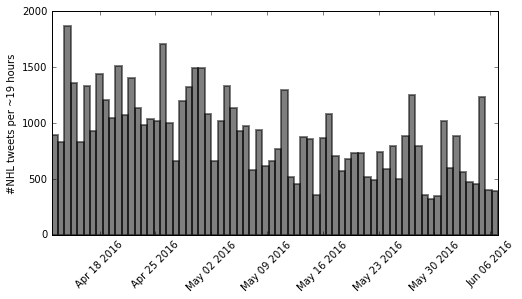

In [51]:
# with plt.xkcd():
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)

ax.bar(my_hist_times['#nhl'], my_hists['#nhl'][0],
       color='black', lw=2, alpha=0.5, width=0.8)

tks = ax.xaxis.get_majorticklabels()
plt.setp(tks, rotation=45)

bar_width = df.created_at
ax.set_ylabel('#NHL tweets per ~{} hours'.format(int(nhl_bin_width)))

plt.savefig('figures/#nhl_hist.png', bbox_inches='tight', dpi=144)

In [36]:
all_players = ['Lundqvist', 'Mrazek', 'Giroux', 'Jagr',
               'Tavares', 'Ovechkin', 'Kucherov', 'Crosby',
               'Pavelski', 'Tarasenko', 'Forsberg', 'Seguin',
               'Kane', 'Perry', 'Pominville', 'Lucic']
east_players = all_players[:8]
west_players = all_players[8:][::-1]

In [37]:
east_players

['Lundqvist',
 'Mrazek',
 'Giroux',
 'Jagr',
 'Tavares',
 'Ovechkin',
 'Kucherov',
 'Crosby']

In [38]:
west_players

['Lucic',
 'Pominville',
 'Perry',
 'Kane',
 'Seguin',
 'Forsberg',
 'Tarasenko',
 'Pavelski']

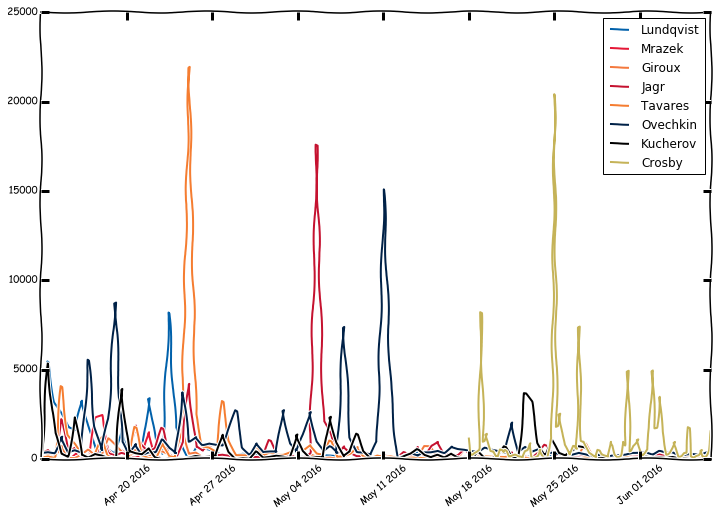

In [53]:
with plt.xkcd():
    fig = plt.figure(figsize=(12,8))
    for i, player in enumerate(east_players):
        ax = plt.subplot(111)
        ax.plot(my_hist_times[player], my_hists[player][0],
                label=player,
                color=colors_dict[player], linewidth=2)
        # ax.set_ylim(0, 1000)
        
        tks = ax.xaxis.get_majorticklabels()
        plt.setp(tks, rotation=40)
        
plt.legend()        
plt.savefig('figures/east_players.png', bbox_inches='tight', dpi=144)

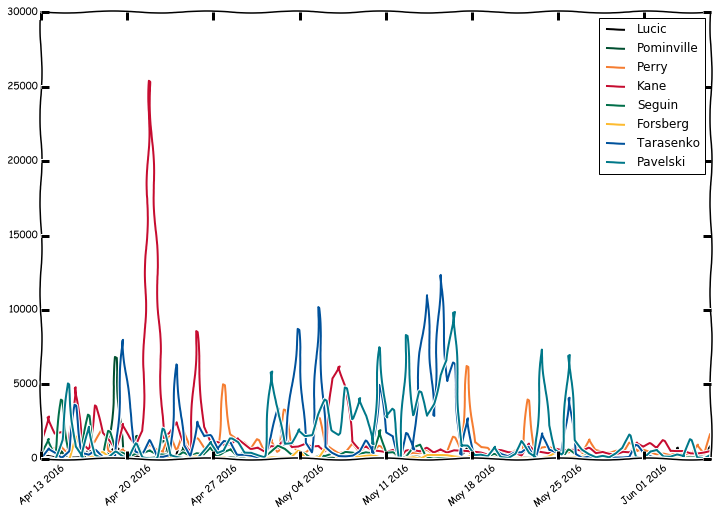

In [54]:
with plt.xkcd():
    fig = plt.figure(figsize=(12,8))
    for i, player in enumerate(west_players):
        ax = plt.subplot(111)
        ax.plot(my_hist_times[player], my_hists[player][0],
                label=player,
                color=colors_dict[player], linewidth=2)
        #ax.set_ylim(0, 1000)
        
        tks = ax.xaxis.get_majorticklabels()
        plt.setp(tks, rotation=40)
        
plt.legend()        
plt.savefig('figures/west_players.png', bbox_inches='tight', dpi=144)

### Most influential twitter users
Determine influnce based on number of favorites + retweets on all original tweets. Also look at users who post the most and the highest post/(likes + retweets) ratio.

In [41]:
df_originals = df[(df.RT == False)]
df_originals.head()

,created_at,favorite_count,followers_count,friends_count,retweet_count,screen_name,search_phrase,text,RT
1,2016-05-18 23:59:17,5,6381,646,2,BWest_Trib,Crosby,"OK, 1 more bit about Kunitz. I got a few ?'s a...",False
4,2016-05-18 23:58:36,0,20,137,0,t4tuck61,Crosby,@NHLTonight how's Crosby the best # doesn't ki...,False
5,2016-05-18 23:58:09,2,403,306,0,philip121212,Crosby,@GreenFlyKnight1 @KANE_4_LIFE @killMOOSEkill @...,False
7,2016-05-18 23:57:50,1,3999,262,0,Sportlogiq,Crosby,ES scoring-chance leaders (last game):\n\nKill...,False
8,2016-05-18 23:57:50,1,3999,262,0,Sportlogiq,Crosby,ES scoring-chance leaders (last game):\n\nKill...,False


In [42]:
unique_names = np.unique(df_originals.screen_name)
all_users = {'influence': {user: 0 for user in unique_names},
             'count': dict(Counter(df_originals.screen_name))}

In [43]:
for user, L, R in zip(df_originals.screen_name,
                      df_originals.favorite_count,
                      df_originals.retweet_count):
    all_users['influence'][user] += (L + R)

In [44]:
all_users['ratio'] = {user: all_users['influence'][user]/all_users['count'][user] for user in unique_names}

In [45]:
# For sorting lists of tuples
import operator

sorted_users = {}
for key in all_users.keys():
    sorted_users[key] = sorted(all_users[key].items(), key=operator.itemgetter(1))[::-1]

In [46]:
for key in sorted_users.keys():
    print(key)
    print(np.array(sorted_users[key]).shape)

ratio
(102047, 2)
count
(102047, 2)
influence
(102047, 2)


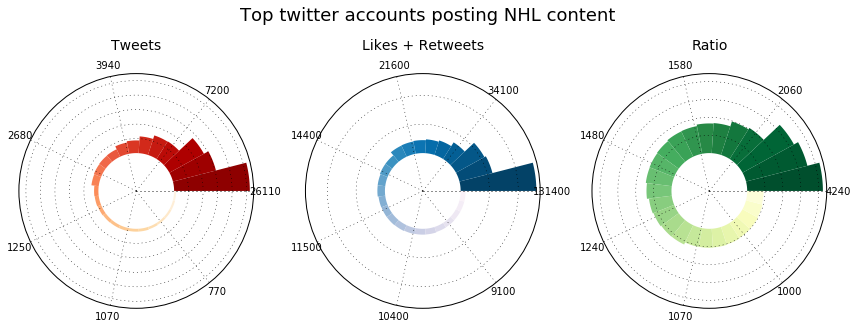

In [82]:
fig = plt.figure(figsize=(12, 8))

N = 25 # len(sorted_users['count'])

c1 = sns.color_palette("OrRd", N)
c2 = sns.color_palette("PuBu", N)
c3 = sns.color_palette("YlGn", N)




ax = plt.subplot(131, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['count'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c1[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(round(y[int(x/np.pi/2*N)], -1)) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Tweets', y=1.08, fontsize=14)




ax = plt.subplot(132, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['influence'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c2[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(round(y[int(x/np.pi/2*N)], -2)) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Likes + Retweets', y=1.08, fontsize=14)




ax = plt.subplot(133, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['ratio'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c3[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(int(round(y[int(x/np.pi/2*N)], -1))) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Ratio', y=1.08, fontsize=14)




plt.tight_layout()
plt.suptitle('Top twitter accounts posting NHL content', y=0.82, fontsize=18)
plt.savefig('figures/count_influence_ratio_circles.png', bbox_inches='tight', dpi=144)

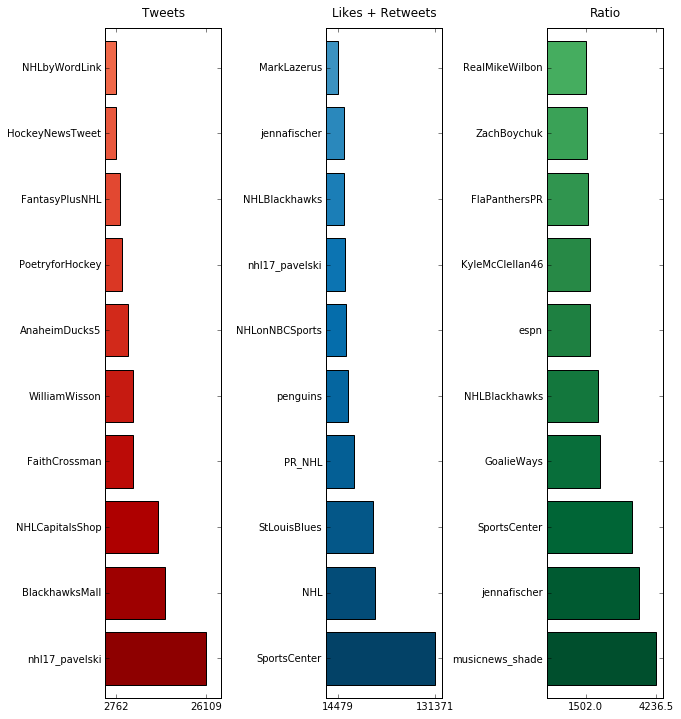

In [118]:
fig = plt.figure(figsize=(10, 12))

ax = plt.subplot(131)
x = np.arange(0, 10, 1)
y = [sorted_users['count'][i][1] for i in range(10)]
ax.barh(x, y, color=c1[::-1])
ax.set_title('Tweets', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['count'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])

ax = plt.subplot(132)
x = np.arange(0, 10, 1)
y = [sorted_users['influence'][i][1] for i in range(10)]
ax.barh(x, y, color=c2[::-1])
ax.set_title('Likes + Retweets', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['influence'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])

ax = plt.subplot(133)
x = np.arange(0, 10, 1)
y = [sorted_users['ratio'][i][1] for i in range(10)]
ax.barh(x, y, color=c3[::-1])
ax.set_title('Ratio', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['ratio'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])

plt.subplots_adjust(wspace=0.9)

plt.savefig('figures/count_influence_ratio_bar.png', bbox_inches='tight', dpi=144)

26109